In [ ]:
import torch
import torch.nn as nn 


## Configuration
Set all hyperparameters and paths in one place

In [ ]:
# Cell: Configuration (update learning_rate)

# Configuration Parameters
CONFIG = {
    # Data paths
    'data_path': './AMDA_SIDED',
    
    # Model hyperparameters
    'input_size': 1,
    'output_size': 5,  # Number of appliances
    'hidden_size': 128,
    'num_layers': 8,   # Increased to 8 to match paper depth
    'num_channels': [64, 64, 64, 64, 128, 128, 128, 128],  # 8 layers for TCN (Paper uses 8 layers)
    
    # Training hyperparameters
    'num_epochs': 20,
    'learning_rate': 0.001,  
    'batch_size': 64,
    'seq_length': 288, 
    'test_size': 0.2,
    'validation_split': 0.1,  
    
    # Warmup scheduler settings
    'warmup_epochs': 3,  
    'warmup_start_lr': 1e-6,  
    'min_lr': 1e-6,  
    
    # Optimization settings
   
    'early_stopping_patience': 5, 

    'num_workers': 0,  
    'pin_memory': True, 
    
    # Other settings
    'random_state': 42,
    'dropout': 0.33 # Increased to 0.33 (Paper specification)
}
device ="cuda"
print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

### 🔧 Quick Configuration Guide

**To modify training parameters**, edit the CONFIG dictionary in the cell below:

- `num_epochs`: Number of training epochs (default: 20)
- `learning_rate`: Learning rate for optimization (default: 0.001)
- `batch_size`: Batch size for training (default: 64)
- `seq_length`: Sequence length for time-series models (default: 50)
- `hidden_size`: Hidden layer size for LSTM/GRU (default: 128)
- `num_layers`: Number of layers in LSTM/GRU (default: 3)

**Tip**: Start with fewer epochs (e.g., 5-10) for quick testing!

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load data by location for Domain Adaptation
def load_data_by_location(base_path='./AMDA_SIDED', target_locations=['Tokyo'], source_locations=['LA', 'Offenbach'], resample_rule='5min'):
    """
    Load data split by location for Domain Adaptation tasks.
    Args:
        base_path: Path to data
        target_locations: List of locations to use for testing (Target Domain)
        source_locations: List of locations to use for training (Source Domain)
        resample_rule: Pandas resampling rule (e.g., '5min' for 5 minutes). None to disable.
    """
    train_dfs = []
    test_dfs = []
    
    facilities = ['Dealer', 'Logistic', 'Office']
    
    print(f"Loading Data from: {base_path}")
    if resample_rule:
        print(f"⚠️ Resampling data to {resample_rule} intervals (Paper Requirement)")
    
    for facility in facilities:
        # Load Source Domain (Training Data)
        for loc in source_locations:
            file_path = Path(base_path) / facility / f'augmented_{facility}_{loc}.csv'
            if file_path.exists():
                df = pd.read_csv(file_path)
                
                # Resample if requested (Paper uses 5-min intervals)
                if resample_rule:
                    # Assuming data has no timestamp index, we create a dummy one or just average every N rows
                    # Since SIDED is 1-min resolution, 5-min resample = average every 5 rows
                    if 'timestamp' in df.columns:
                        df['timestamp'] = pd.to_datetime(df['timestamp'])
                        df = df.set_index('timestamp').resample(resample_rule).mean().dropna().reset_index()
                    else:
                        # Fallback: Group by index // 5 for 1-min to 5-min conversion
                        df = df.groupby(df.index // 5).mean()
                
                df['facility'] = facility
                df['location'] = loc
                df['domain'] = 'source'
                train_dfs.append(df)
                print(f"  [TRAIN/Source] Loaded {facility}_{loc}: {len(df)} samples")
            else:
                print(f"  [WARN] File not found: {file_path}")
                
        # Load Target Domain (Testing Data)
        for loc in target_locations:
            file_path = Path(base_path) / facility / f'augmented_{facility}_{loc}.csv'
            if file_path.exists():
                df = pd.read_csv(file_path)
                
                # Resample
                if resample_rule:
                    if 'timestamp' in df.columns:
                        df['timestamp'] = pd.to_datetime(df['timestamp'])
                        df = df.set_index('timestamp').resample(resample_rule).mean().dropna().reset_index()
                    else:
                        df = df.groupby(df.index // 5).mean()

                df['facility'] = facility
                df['location'] = loc
                df['domain'] = 'target'
                test_dfs.append(df)
                print(f"  [TEST/Target]  Loaded {facility}_{loc}: {len(df)} samples")
            else:
                print(f"  [WARN] File not found: {file_path}")
    
    if not train_dfs or not test_dfs:
        raise ValueError("Could not load data. Check paths and locations.")

    train_df = pd.concat(train_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)
    
    print(f"\nTotal Training Samples (Source): {len(train_df)}")
    print(f"Total Testing Samples (Target): {len(test_df)}")
    
    return train_df, test_df

# Define Domain Split (Paper Replication Setting)
# Scenario: Train on LA & Offenbach, Test on Tokyo
source_locs = ['LA', 'Offenbach']
target_locs = ['Tokyo']

print(f"Preparing Domain Adaptation Split:")
print(f"Source (Train): {source_locs}")
print(f"Target (Test): {target_locs}")

# Load with 5-minute resampling
train_data, test_data = load_data_by_location(
    CONFIG['data_path'], 
    target_locations=target_locs, 
    source_locations=source_locs,
    resample_rule='5min' # Enable resampling
)

In [ ]:
# Check for missing values
print("Checking for missing values in Training Data (Source):")
print(train_data.isnull().sum())

print("\nChecking for missing values in Testing Data (Target):")
print(test_data.isnull().sum())

# Check for infinite values
print("\nChecking for infinite values:")
print("Train infinite:", np.isinf(train_data.select_dtypes(include=np.number)).sum().sum())
print("Test infinite:", np.isinf(test_data.select_dtypes(include=np.number)).sum().sum())

In [ ]:
# Handle missing values
print(f"Original Train Shape: {train_data.shape}")
print(f"Original Test Shape: {test_data.shape}")

train_data = train_data.dropna()
test_data = test_data.dropna()

print(f"New Train Shape: {train_data.shape}")
print(f"New Test Shape: {test_data.shape}")

print("\nVerifying missing values after cleanup:")
print("Train missing:", train_data.isnull().sum().sum())
print("Test missing:", test_data.isnull().sum().sum())

In [ ]:
# Define appliance columns (needed if running cells out of order)
appliance_columns = ['EVSE', 'PV', 'CS', 'CHP', 'BA']

# Inspect Data Statistics to debug huge error values
print("Training Data Statistics (Raw):")
# Ensure we only check columns that exist
cols_to_check = [c for c in appliance_columns if c in train_data.columns]
if 'Aggregate' in train_data.columns:
    cols_to_check.append('Aggregate')

print(train_data[cols_to_check].describe().apply(lambda s: s.apply('{0:.2f}'.format)))

print("\nTesting Data Statistics (Raw):")
print(test_data[cols_to_check].describe().apply(lambda s: s.apply('{0:.2f}'.format)))

# Check for extreme outliers
print("\nOutlier Analysis:")
for col in [c for c in appliance_columns if c in train_data.columns]:
    # Check if it's a generation appliance (mostly negative)
    is_generation = train_data[col].mean() < -1 # Threshold to detect generation
    
    if is_generation:
        # For generation (negative), check the lower tail (large negative values)
        q01 = train_data[col].quantile(0.01)
        min_val = train_data[col].min()
        # Avoid division by zero
        ratio = min_val / q01 if q01 < 0 else 0
        print(f"{col} (Gen): 1st percentile={q01:.2f}, Min={min_val:.2f}, Ratio={ratio:.2f}")
    else:
        # For loads (positive), check the upper tail
        q99 = train_data[col].quantile(0.99)
        max_val = train_data[col].max()
        ratio = max_val / q99 if q99 > 0 else 0
        print(f"{col} (Load): 99th percentile={q99:.2f}, Max={max_val:.2f}, Ratio={ratio:.2f}")

## 1. Data Preprocessing
Split data into training and testing sets and create sequences for time-series models

In [ ]:
# Prepare data for NILM (Non-Intrusive Load Monitoring)
appliance_columns = ['EVSE', 'PV', 'CS', 'CHP', 'BA']

# 1. Prepare Training Data (Source Domain)
X_train_raw = train_data['Aggregate'].values.reshape(-1, 1)
y_train_raw = train_data[appliance_columns].values

# 2. Prepare Testing Data (Target Domain)
X_test_raw = test_data['Aggregate'].values.reshape(-1, 1)
y_test_raw = test_data[appliance_columns].values

print(f"Training set (Source): {X_train_raw.shape[0]} samples")
print(f"Testing set (Target): {X_test_raw.shape[0]} samples")

# 3. Normalize
# Important: Fit scaler ONLY on training data to avoid data leakage
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on Train, Transform Train
X_train_scaled = scaler_X.fit_transform(X_train_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw)

# Transform Test (using Train statistics)
X_test_scaled = scaler_X.transform(X_test_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

print("\nData preprocessing completed!")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

## 2. PyTorch Data Preparation
Convert to PyTorch tensors and create DataLoaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Create sequences for time-series models
def create_sequences(X, y, seq_length):
    """Create sequences for LSTM/GRU/TCN models"""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
seq_length = CONFIG['seq_length']
print(f"Creating sequences with length {seq_length}...")
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

print(f"Training sequences: {X_train_seq.shape}")
print(f"Testing sequences: {X_test_seq.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq)

# Create DataLoaders
class NILMDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = CONFIG['batch_size']

# Split training data into train and validation
val_split = CONFIG['validation_split']
val_size = int(len(X_train_tensor) * val_split)
train_size = len(X_train_tensor) - val_size

train_indices = list(range(train_size))
val_indices = list(range(train_size, len(X_train_tensor)))

train_dataset = NILMDataset(X_train_tensor[train_indices], y_train_tensor[train_indices])
val_dataset = NILMDataset(X_train_tensor[val_indices], y_train_tensor[val_indices])
test_dataset = NILMDataset(X_test_tensor, y_test_tensor)

# Optimized DataLoaders with pin_memory for faster GPU transfer
num_workers = 0 if device == 'cpu' else CONFIG['num_workers']
pin_memory = CONFIG['pin_memory'] and device == 'cuda'

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, # Changed to True for training
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=num_workers > 0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=num_workers > 0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=num_workers > 0
)

print(f"\nBatch size: {batch_size}")
print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Testing samples: {len(test_dataset):,}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")
print(f"Workers: {num_workers} | Pin memory: {pin_memory}")
print("\nPyTorch data preparation completed!")

## 3. Model Architectures
Define all deep learning models for NILM task

In [ ]:
# GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, output_size=5):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size=input_size,
                         hidden_size=hidden_size,
                         num_layers=num_layers,
                         batch_first=True,
                         dropout=0.2)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        gru_out, _h_n = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

# CNN-LSTM Model
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, output_size=5):
        super(CNN_LSTM, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=128,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=0.2)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        x = x.permute(0, 2, 1)  # (batch, input_size, seq_len)
        
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        
        lstm_out, (_h_n, _c_n) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Bidirectional LSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, output_size=5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           bidirectional=True,
                           dropout=0.2)
        
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional
        
    def forward(self, x):
        lstm_out, (_h_n, _c_n) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, output_size=5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=0.2)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        lstm_out, (_h_n, _c_n) = self.lstm(x)
        # Use the last hidden state
        out = self.fc(lstm_out[:, -1, :])
        return out
print("Models defined successfully!")

In [ ]:
# Temporal Convolutional Network (TCN)

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCNModel(nn.Module):
    def __init__(self, input_size, num_channels=[64, 128, 128], kernel_size=3, dropout=0.2, output_size=5):
        super(TCNModel, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size,
                                       stride=1, dilation=dilation_size,
                                       padding=padding, dropout=dropout))
        
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], output_size)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        x = x.permute(0, 2, 1)  # (batch, input_size, seq_len)
        x = self.network(x)
        x = x.mean(dim=2)  # Global average pooling
        return self.fc(x)

# Attention Mechanism
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x):
        # x shape: (batch, seq_len, hidden_size)
        attention_weights = self.attention(x)  # (batch, seq_len, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        weighted = x * attention_weights
        return weighted.sum(dim=1)  # (batch, hidden_size)

# Attention + TCN Model (ATCN)
class ATCNModel(nn.Module):
    def __init__(self, input_size, num_channels=[64, 128, 128], kernel_size=3, dropout=0.2, output_size=5):
        super(ATCNModel, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size,
                                       stride=1, dilation=dilation_size,
                                       padding=padding, dropout=dropout))
        
        self.network = nn.Sequential(*layers)
        self.attention = AttentionLayer(num_channels[-1])
        self.fc = nn.Linear(num_channels[-1], output_size)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        x = x.permute(0, 2, 1)  # (batch, input_size, seq_len)
        x = self.network(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, channels)
        x = self.attention(x)  # Apply attention
        return self.fc(x)

print("TCN and ATCN models defined successfully!")

## 4. Training & Evaluation Functions
Define reusable functions for training and evaluating models

In [ ]:
import torch.optim as optim
from tqdm import tqdm
import time
import math

# Backend optimizations (CUDA only)
if torch.cuda.is_available():
    try:
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        try:
            torch.set_float32_matmul_precision('high')
        except Exception:
            pass
    except Exception:
        pass

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, 
                 early_stopping_patience=5, model_name='Model', gradient_clip=1.0):
    """Optimized training with validation, early stopping, AMP, and monitoring"""
    model.to(device)
    use_amp = (device.type == 'cuda')
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    
    history = {'train_loss': [], 'val_loss': [], 'epoch_times': [], 'learning_rates': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"\n{'='*60}\nTraining {model_name}\n{'='*60}")
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        
        for batch_X, batch_y in progress_bar:
            batch_X = batch_X.to(device, non_blocking=True)
            batch_y = batch_y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(batch_X)
                # Detect exploding outputs early
                if not torch.isfinite(outputs).all():
                    print("⚠️ Detected non-finite model outputs. Clamping and continuing.")
                    outputs = torch.nan_to_num(outputs, nan=0.0, posinf=1e6, neginf=-1e6)
                loss = criterion(outputs, batch_y)
            
            if (not math.isfinite(loss.item())) or math.isnan(loss.item()):
                print(f"❌ Invalid loss (NaN/Inf) at epoch {epoch+1}. Stopping training for {model_name}.")
                return history
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip)
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': f'{loss.item():.4f}'})
        
        avg_train_loss = train_loss / max(1, len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.inference_mode():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device, non_blocking=True)
                batch_y = batch_y.to(device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=use_amp):
                    outputs = model(batch_X)
                    if not torch.isfinite(outputs).all():
                        outputs = torch.nan_to_num(outputs, nan=0.0, posinf=1e6, neginf=-1e6)
                    loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / max(1, len(val_loader))
        epoch_time = time.time() - epoch_start_time
        current_lr = optimizer.param_groups[0]['lr']
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['epoch_times'].append(epoch_time)
        history['learning_rates'].append(current_lr)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f} | LR: {current_lr:.6f} | Time: {epoch_time:.2f}s")
        scheduler.step()
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"⚠️ Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.6f}")
                break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"✅ Restored best model with val_loss: {best_val_loss:.6f}")
    return history

def evaluate_model(model, test_loader, criterion, device):
    """Optimized evaluation with memory efficiency + AMP and stability checks"""
    model.to(device)
    model.eval()
    use_amp = (device.type == 'cuda')
    all_predictions = []
    all_targets = []
    test_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc='Evaluating', leave=False):
            batch_X = batch_X.to(device, non_blocking=True)
            batch_y = batch_y.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(batch_X)
                if not torch.isfinite(outputs).all():
                    outputs = torch.nan_to_num(outputs, nan=0.0, posinf=1e6, neginf=-1e6)
                loss = criterion(outputs, batch_y)
            test_loss += loss.item()
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    
    # Sanitize any non-finite values before metric computations
    if not np.isfinite(predictions).all():
        print("⚠️ Non-finite predictions detected. Replacing with zeros.")
        predictions = np.nan_to_num(predictions, nan=0.0, posinf=1e6, neginf=-1e6)
    if not np.isfinite(targets).all():
        print("⚠️ Non-finite targets detected. Replacing with zeros.")
        targets = np.nan_to_num(targets, nan=0.0, posinf=1e6, neginf=-1e6)
    
    avg_test_loss = test_loss / max(1, len(test_loader))
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    return predictions, targets, avg_test_loss

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

In [ ]:
# Cell: Main Execution Loop

def calculate_metrics(targets, predictions, appliance_names):
    """Calculate and print metrics per appliance with robust sanitization"""
    results = {}
    
    # Inverse transform to get real power values (Watts)
    targets_real = scaler_y.inverse_transform(targets)
    predictions_real = scaler_y.inverse_transform(predictions)
    
    # Sanitize non-finite values post inverse transform
    def sanitize(arr, name):
        if not np.isfinite(arr).all():
            finite_mask = np.isfinite(arr)
            if finite_mask.any():
                median_vals = np.median(arr[finite_mask], axis=0)
                arr[~finite_mask] = median_vals
            else:
                arr[:] = 0.0
            print(f"⚠️ Sanitized non-finite values in {name}.")
        # Clamp extreme outliers to 10x max(abs(targets)) to avoid metric distortion
        max_ref = np.max(np.abs(targets_real)) if np.isfinite(targets_real).any() else 1.0
        arr[:] = np.clip(arr, -10*max_ref, 10*max_ref)
        return arr
    
    predictions_real = sanitize(predictions_real, 'predictions_real')
    targets_real = sanitize(targets_real, 'targets_real')
    
    # Correctly handle negative values (Generation vs Load)
    load_appliances = ['EVSE', 'CS', 'BA']
    generation_appliances = ['PV', 'CHP']
    
    print("\n" + "="*80)
    print("       PER-APPLIANCE PERFORMANCE METRICS")
    print("="*80)
    print(f"{'Appliance':<10} | {'MAE (W)':<10} | {'MAE (MW)':<10} | {'MSE (MW²)':<12} | {'R2 Score':<10}")
    print("-" * 80)
    
    for i, app_name in enumerate(appliance_names):
        if app_name in load_appliances:
            predictions_real[:, i] = np.maximum(predictions_real[:, i], 0)
        elif app_name in generation_appliances:
            predictions_real[:, i] = np.minimum(predictions_real[:, i], 0)
            
        mae_w = mean_absolute_error(targets_real[:, i], predictions_real[:, i])
        mse_w = mean_squared_error(targets_real[:, i], predictions_real[:, i])
        r2 = r2_score(targets_real[:, i], predictions_real[:, i])
        mae_mw = mae_w / 1e6
        mse_mw = mse_w / (1e6 ** 2)
        
        results[app_name] = {'MAE_W': mae_w, 'MAE_MW': mae_mw, 'MSE_W': mse_w, 'MSE_MW2': mse_mw, 'R2': r2}
        print(f"{app_name:<10} | {mae_w:<10.2f} | {mae_mw:<10.6f} | {mse_mw:<12.6f} | {r2:<10.4f}")
    
    print("="*80)
    return results, predictions_real, targets_real

# Define models to train
models_to_train = {
    'BiLSTM': BiLSTMModel(input_size=CONFIG['input_size'], 
                          hidden_size=CONFIG['hidden_size'], 
                          output_size=CONFIG['output_size']),
    'TCN': TCNModel(input_size=CONFIG['input_size'], 
                    num_channels=CONFIG['num_channels'], 
                    output_size=CONFIG['output_size']),
    'ATCN': ATCNModel(input_size=CONFIG['input_size'], 
                      num_channels=CONFIG['num_channels'], 
                      output_size=CONFIG['output_size']),
}

criterion = nn.MSELoss()
num_epochs = CONFIG['num_epochs']
experiment_results = {}

save_dir = Path('./saved_models')
save_dir.mkdir(exist_ok=True)

print(f"📂 Training on Dataset from: {CONFIG['data_path']}")
print(f"💾 Models will be saved to: {save_dir.absolute()}")

for model_name, model in models_to_train.items():
    print(f"\n\n🚀 STARTING TRAINING FOR: {model_name}")
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['warmup_start_lr'])
    warmup_epochs = CONFIG['warmup_epochs']
    total_epochs = num_epochs
    
    def warmup_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        return 1.0
    
    warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lambda)
    cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=total_epochs - warmup_epochs,
        eta_min=CONFIG['min_lr']
    )
    
    class WarmupCosineScheduler:
        def __init__(self, warmup_scheduler, cosine_scheduler, warmup_epochs):
            self.warmup_scheduler = warmup_scheduler
            self.cosine_scheduler = cosine_scheduler
            self.warmup_epochs = warmup_epochs
            self.current_epoch = 0
        def step(self):
            if self.current_epoch < self.warmup_epochs:
                self.warmup_scheduler.step()
                for pg in self.cosine_scheduler.optimizer.param_groups:
                    pg['lr'] = CONFIG['learning_rate'] * warmup_lambda(self.current_epoch)
            else:
                self.cosine_scheduler.step()
            self.current_epoch += 1
    
    scheduler = WarmupCosineScheduler(warmup_scheduler, cosine_scheduler, warmup_epochs)
    
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=num_epochs,
        device=device,
        early_stopping_patience=CONFIG['early_stopping_patience'],
        model_name=model_name,
        gradient_clip=CONFIG.get('gradient_clip', 1.0)
    )
    
    model_save_path = save_dir / f"{model_name}_best.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"💾 Model saved: {model_save_path}")
    

print("\n✅ All Trainings completed!")

## 5. Standalone Model Evaluation
Load saved models and evaluate with robust metrics (no retraining needed)

In [13]:
# Standalone Evaluation Cell - Load and Evaluate Saved Models
# This cell can run independently without retraining

def evaluate_saved_model_robust(model, model_path, test_loader, device, appliance_names):
    """
    Load a saved model and evaluate with robust metrics.
    Clamps predictions in standardized space before inverse_transform to prevent overflow.
    """
    # Load saved weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    print(f"Evaluating {model_path.name}...")
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc='Evaluating', leave=False):
            batch_X = batch_X.to(device, non_blocking=True)
            batch_y = batch_y.to(device, non_blocking=True)
            
            # No AMP in evaluation for simplicity
            outputs = model(batch_X)
            
            # Clamp outputs in standardized space (prevent extreme values)
            outputs = torch.clamp(outputs, min=-8.0, max=8.0)
            
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    
    # Additional safety: sanitize before inverse_transform
    predictions = np.nan_to_num(predictions, nan=0.0, posinf=0.0, neginf=0.0)
    predictions = np.clip(predictions, -8.0, 8.0)
    
    targets = np.nan_to_num(targets, nan=0.0, posinf=0.0, neginf=0.0)
    targets = np.clip(targets, -8.0, 8.0)
    
    # Inverse transform with float64 to reduce overflow risk
    targets_real = scaler_y.inverse_transform(targets.astype(np.float64)).astype(np.float32)
    predictions_real = scaler_y.inverse_transform(predictions.astype(np.float64)).astype(np.float32)
    
    # Final sanitization
    def sanitize_final(arr, name):
        if not np.isfinite(arr).all():
            print(f"⚠️ Sanitizing non-finite values in {name}")
            arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
        return arr
    
    predictions_real = sanitize_final(predictions_real, 'predictions')
    targets_real = sanitize_final(targets_real, 'targets')
    
    # Apply appliance-specific clipping
    load_appliances = ['EVSE', 'CS', 'BA']
    generation_appliances = ['PV', 'CHP']
    
    for i, app_name in enumerate(appliance_names):
        if app_name in load_appliances:
            predictions_real[:, i] = np.maximum(predictions_real[:, i], 0)
        elif app_name in generation_appliances:
            predictions_real[:, i] = np.minimum(predictions_real[:, i], 0)
    
    # Calculate metrics
    print("\n" + "="*80)
    print(f"       {model_path.stem.upper()} - PERFORMANCE METRICS")
    print("="*80)
    print(f"{'Appliance':<10} | {'MAE (W)':<10} | {'MAE (MW)':<10} | {'MSE (MW²)':<12} | {'R2 Score':<10}")
    print("-" * 80)
    
    results = {}
    for i, app_name in enumerate(appliance_names):
        mae_w = mean_absolute_error(targets_real[:, i], predictions_real[:, i])
        mse_w = mean_squared_error(targets_real[:, i], predictions_real[:, i])
        r2 = r2_score(targets_real[:, i], predictions_real[:, i])
        mae_mw = mae_w / 1e6
        mse_mw = mse_w / (1e6 ** 2)
        
        results[app_name] = {'MAE_W': mae_w, 'MAE_MW': mae_mw, 'MSE_W': mse_w, 'MSE_MW2': mse_mw, 'R2': r2}
        print(f"{app_name:<10} | {mae_w:<10.2f} | {mae_mw:<10.6f} | {mse_mw:<12.6f} | {r2:<10.4f}")
    
    print("="*80 + "\n")
    return results, predictions_real, targets_real

# Evaluate all saved models
saved_model_dir = Path('./saved_models')
model_configs = {
    'TCN_best.pth': TCNModel(input_size=CONFIG['input_size'], 
                              num_channels=CONFIG['num_channels'], 
                              output_size=CONFIG['output_size']),
    'ATCN_best.pth': ATCNModel(input_size=CONFIG['input_size'], 
                                num_channels=CONFIG['num_channels'], 
                                output_size=CONFIG['output_size']),
    'BiLSTM_best.pth': BiLSTMModel(input_size=CONFIG['input_size'], 
                                    hidden_size=CONFIG['hidden_size'], 
                                    output_size=CONFIG['output_size'])
}

eval_results = {}

for model_file, model_template in model_configs.items():
    model_path = saved_model_dir / model_file
    if model_path.exists():
        results, preds, targs = evaluate_saved_model_robust(
            model_template, 
            model_path, 
            test_loader, 
            device, 
            appliance_columns
        )
        eval_results[model_path.stem] = {
            'metrics': results,
            'predictions': preds,
            'targets': targs
        }
    else:
        print(f"⚠️ Model not found: {model_path}")

print("\n✅ Evaluation completed for all saved models!")

Evaluating TCN_best.pth...



       TCN_BEST - PERFORMANCE METRICS
Appliance  | MAE (W)    | MAE (MW)   | MSE (MW²)    | R2 Score  
--------------------------------------------------------------------------------
EVSE       | 5007.73    | 0.005008   | 0.000148     | 0.8045    
PV         | 42130.66   | 0.042131   | 0.008441     | 0.9484    
CS         | 25613.60   | 0.025614   | 0.005217     | 0.7420    
CHP        | 39977.50   | 0.039977   | 0.003676     | 0.9722    
BA         | 44809.81   | 0.044810   | 0.004784     | 0.9365    

Evaluating ATCN_best.pth...



       ATCN_BEST - PERFORMANCE METRICS
Appliance  | MAE (W)    | MAE (MW)   | MSE (MW²)    | R2 Score  
--------------------------------------------------------------------------------
EVSE       | 4441.10    | 0.004441   | 0.000130     | 0.8283    
PV         | 40218.49   | 0.040218   | 0.008210     | 0.9498    
CS         | 25419.77   | 0.025420   | 0.005339     | 0.7360    
CHP        | 43459.92   | 0.043460   | 0.004547     | 0.9656    
BA         | 46514.52   | 0.046515   | 0.005468     | 0.9274    

Evaluating BiLSTM_best.pth...



       BILSTM_BEST - PERFORMANCE METRICS
Appliance  | MAE (W)    | MAE (MW)   | MSE (MW²)    | R2 Score  
--------------------------------------------------------------------------------
EVSE       | 2792.22    | 0.002792   | 0.000083     | 0.8905    
PV         | 32551.82   | 0.032552   | 0.007862     | 0.9519    
CS         | 26008.88   | 0.026009   | 0.006143     | 0.6963    
CHP        | 43564.61   | 0.043565   | 0.005695     | 0.9569    
BA         | 46096.07   | 0.046096   | 0.006327     | 0.9160    


✅ Evaluation completed for all saved models!


## 6. Evaluation Visualizations
Comprehensive plots for model performance analysis

C:\Users\Skander\AppData\Local\Temp\ipykernel_9508\3993447011.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


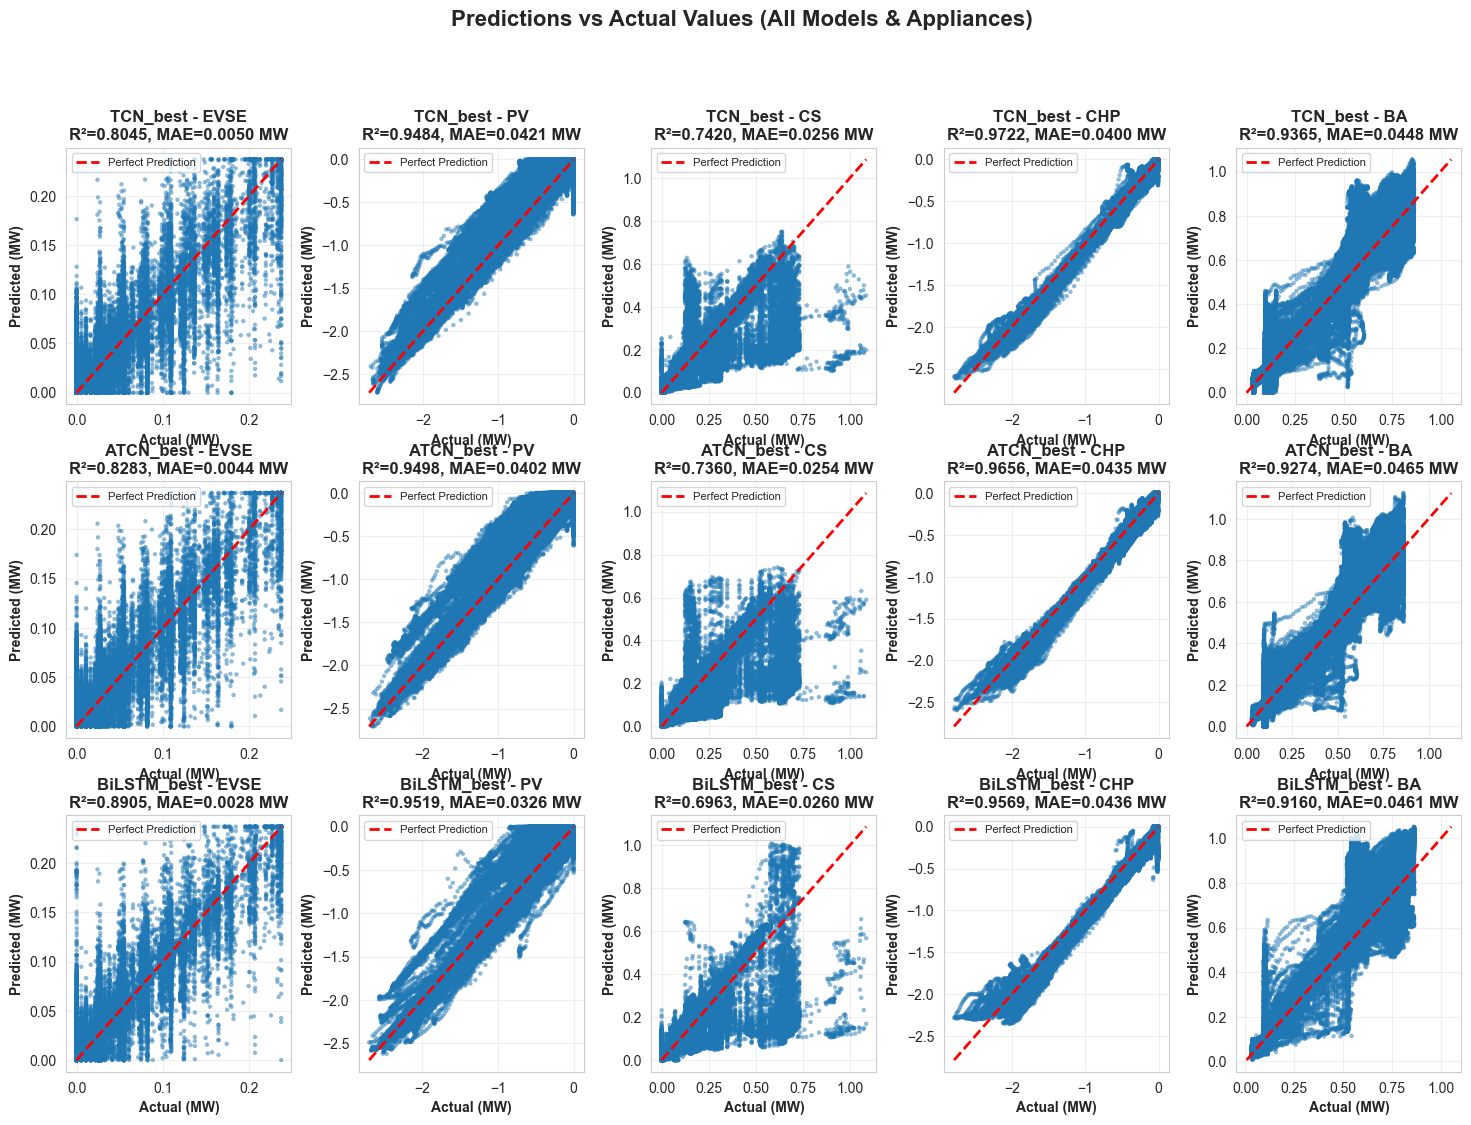

C:\Users\Skander\AppData\Local\Temp\ipykernel_9508\3993447011.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


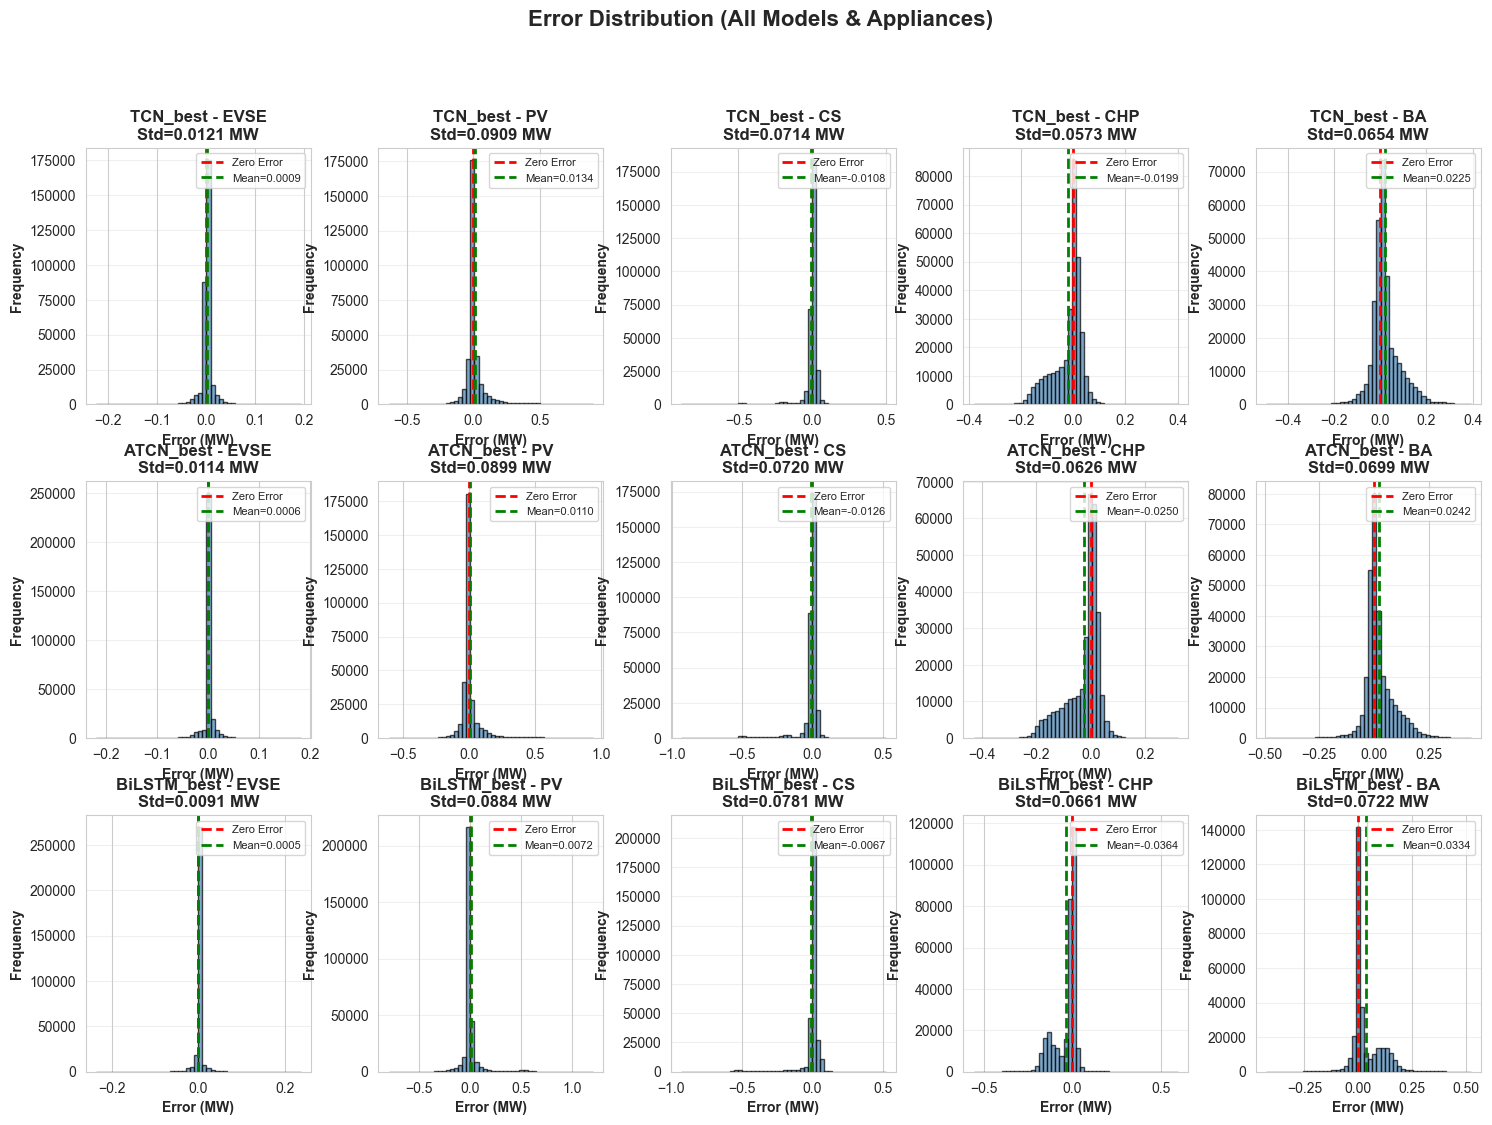

C:\Users\Skander\AppData\Local\Temp\ipykernel_9508\3993447011.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


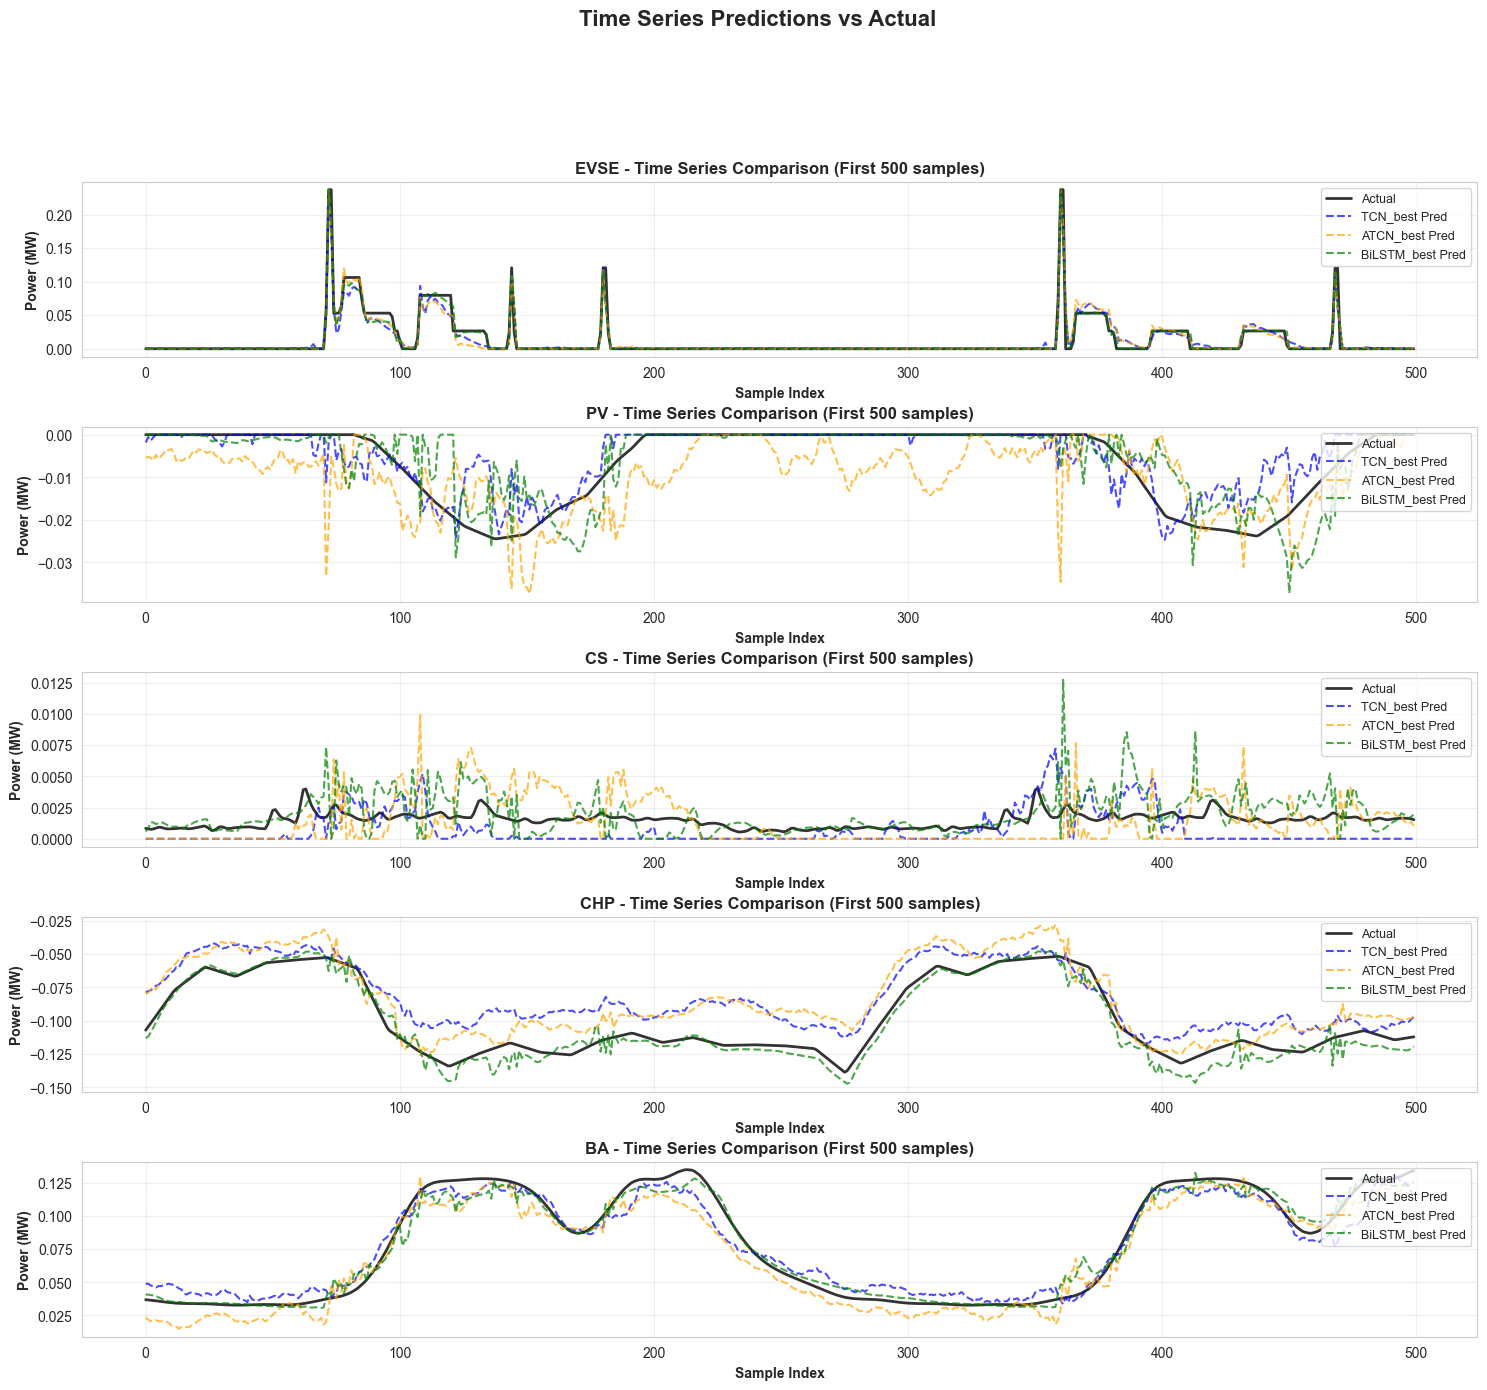

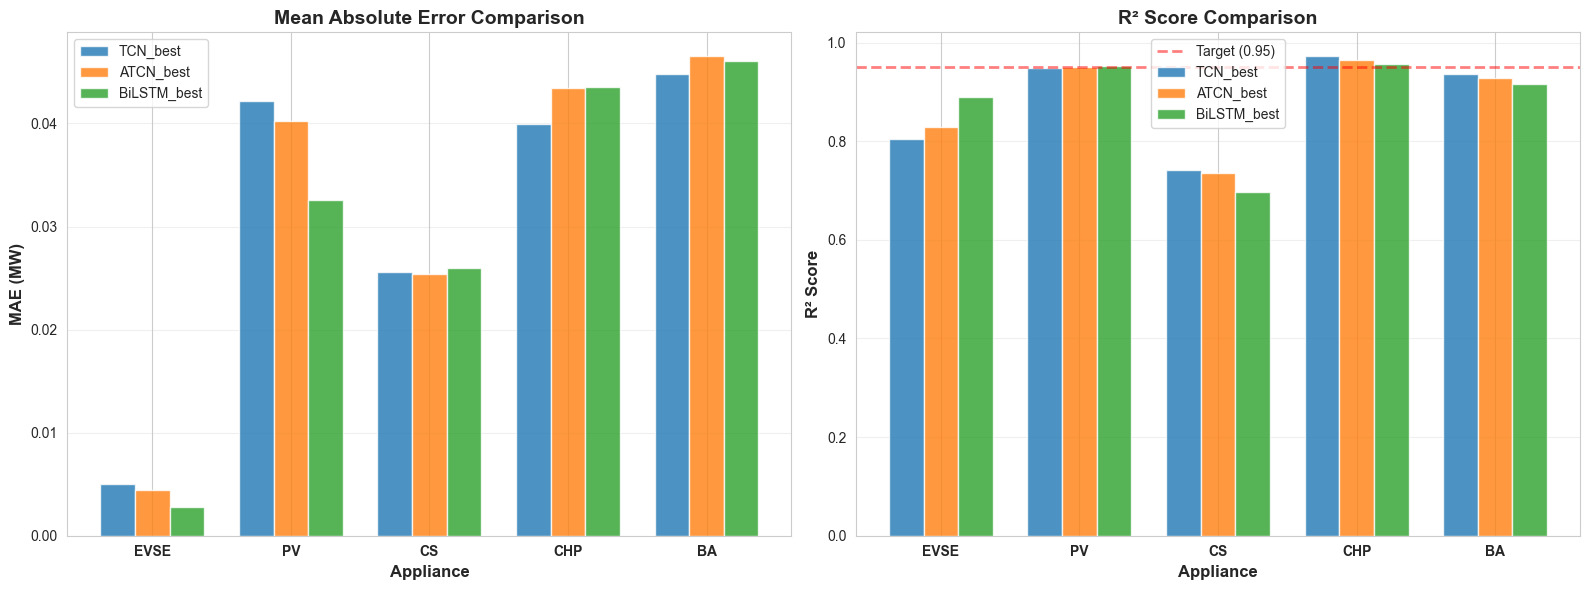

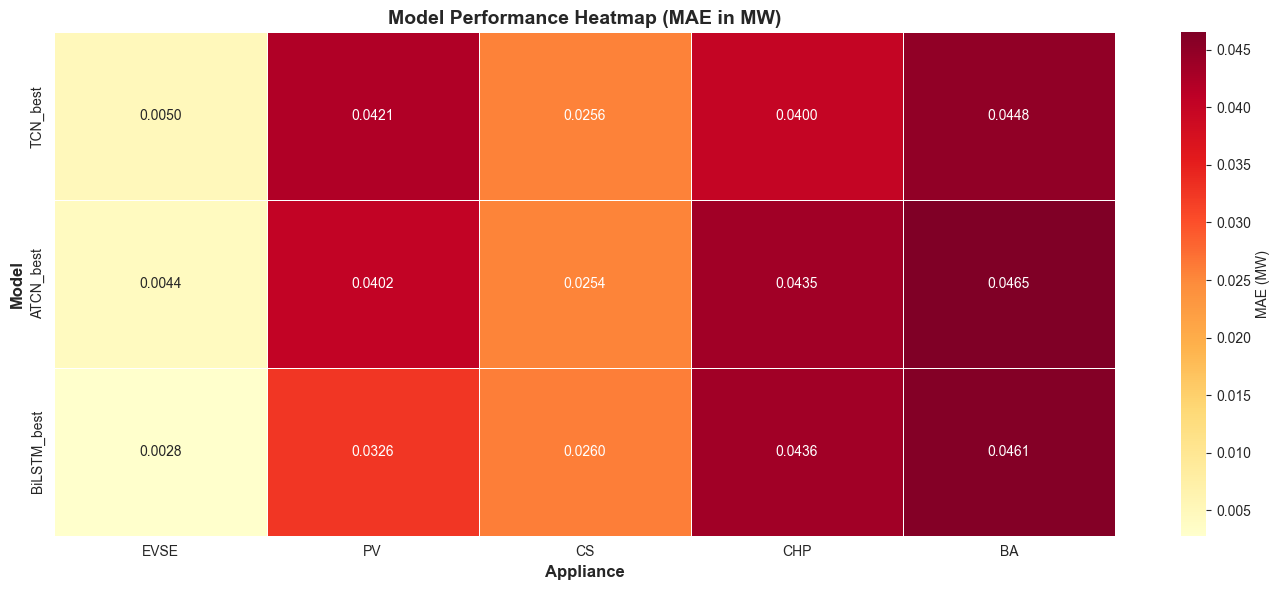

✅ All visualizations generated successfully!


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

def plot_evaluation_results(eval_results, appliance_names):
    """
    Create comprehensive visualization of evaluation results
    """
    n_models = len(eval_results)
    n_appliances = len(appliance_names)
    
    # 1. Predictions vs Actual (Scatter Plots) - All Models
    fig1 = plt.figure(figsize=(18, 4 * n_models))
    gs1 = GridSpec(n_models, n_appliances, figure=fig1, hspace=0.3, wspace=0.3)
    
    for model_idx, (model_name, data) in enumerate(eval_results.items()):
        predictions = data['predictions']
        targets = data['targets']
        
        for app_idx, app_name in enumerate(appliance_names):
            ax = fig1.add_subplot(gs1[model_idx, app_idx])
            
            # Convert to MW for better readability
            pred_mw = predictions[:, app_idx] / 1e6
            targ_mw = targets[:, app_idx] / 1e6
            
            # Scatter plot
            ax.scatter(targ_mw, pred_mw, alpha=0.5, s=10, edgecolors='none')
            
            # Perfect prediction line
            min_val = min(targ_mw.min(), pred_mw.min())
            max_val = max(targ_mw.max(), pred_mw.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
            
            # Calculate R²
            r2 = data['metrics'][app_name]['R2']
            mae_mw = data['metrics'][app_name]['MAE_MW']
            
            ax.set_xlabel('Actual (MW)', fontweight='bold')
            ax.set_ylabel('Predicted (MW)', fontweight='bold')
            ax.set_title(f'{model_name} - {app_name}\nR²={r2:.4f}, MAE={mae_mw:.4f} MW', fontweight='bold')
            ax.legend(loc='upper left', fontsize=8)
            ax.grid(True, alpha=0.3)
    
    fig1.suptitle('Predictions vs Actual Values (All Models & Appliances)', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # 2. Error Distribution (Histograms)
    fig2 = plt.figure(figsize=(18, 4 * n_models))
    gs2 = GridSpec(n_models, n_appliances, figure=fig2, hspace=0.3, wspace=0.3)
    
    for model_idx, (model_name, data) in enumerate(eval_results.items()):
        predictions = data['predictions']
        targets = data['targets']
        
        for app_idx, app_name in enumerate(appliance_names):
            ax = fig2.add_subplot(gs2[model_idx, app_idx])
            
            # Calculate errors in MW
            errors_mw = (predictions[:, app_idx] - targets[:, app_idx]) / 1e6
            
            # Histogram
            ax.hist(errors_mw, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
            
            # Stats
            mean_error = errors_mw.mean()
            std_error = errors_mw.std()
            
            # Vertical line at zero
            ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
            ax.axvline(mean_error, color='green', linestyle='--', linewidth=2, label=f'Mean={mean_error:.4f}')
            
            ax.set_xlabel('Error (MW)', fontweight='bold')
            ax.set_ylabel('Frequency', fontweight='bold')
            ax.set_title(f'{model_name} - {app_name}\nStd={std_error:.4f} MW', fontweight='bold')
            ax.legend(loc='upper right', fontsize=8)
            ax.grid(True, alpha=0.3, axis='y')
    
    fig2.suptitle('Error Distribution (All Models & Appliances)', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # 3. Time Series Comparison (First 500 samples)
    n_samples = min(500, predictions.shape[0])
    
    fig3 = plt.figure(figsize=(18, 3 * n_appliances))
    gs3 = GridSpec(n_appliances, 1, figure=fig3, hspace=0.4)
    
    colors = ['blue', 'orange', 'green']
    
    for app_idx, app_name in enumerate(appliance_names):
        ax = fig3.add_subplot(gs3[app_idx, 0])
        
        # Plot actual values (only once)
        targets_first_model = list(eval_results.values())[0]['targets'][:n_samples, app_idx] / 1e6
        ax.plot(targets_first_model, color='black', linewidth=2, label='Actual', alpha=0.8)
        
        # Plot predictions from all models
        for model_idx, (model_name, data) in enumerate(eval_results.items()):
            predictions_sample = data['predictions'][:n_samples, app_idx] / 1e6
            ax.plot(predictions_sample, color=colors[model_idx % len(colors)], 
                   linewidth=1.5, label=f'{model_name} Pred', alpha=0.7, linestyle='--')
        
        ax.set_xlabel('Sample Index', fontweight='bold')
        ax.set_ylabel('Power (MW)', fontweight='bold')
        ax.set_title(f'{app_name} - Time Series Comparison (First {n_samples} samples)', fontweight='bold')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    fig3.suptitle('Time Series Predictions vs Actual', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # 4. Model Comparison Bar Chart (MAE & R²)
    fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Prepare data
    model_names_list = list(eval_results.keys())
    x = np.arange(n_appliances)
    width = 0.25
    
    # MAE Comparison
    for model_idx, model_name in enumerate(model_names_list):
        mae_values = [eval_results[model_name]['metrics'][app]['MAE_MW'] for app in appliance_names]
        offset = width * (model_idx - len(model_names_list)/2 + 0.5)
        ax1.bar(x + offset, mae_values, width, label=model_name, alpha=0.8)
    
    ax1.set_xlabel('Appliance', fontweight='bold', fontsize=12)
    ax1.set_ylabel('MAE (MW)', fontweight='bold', fontsize=12)
    ax1.set_title('Mean Absolute Error Comparison', fontweight='bold', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(appliance_names, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # R² Comparison
    for model_idx, model_name in enumerate(model_names_list):
        r2_values = [eval_results[model_name]['metrics'][app]['R2'] for app in appliance_names]
        offset = width * (model_idx - len(model_names_list)/2 + 0.5)
        ax2.bar(x + offset, r2_values, width, label=model_name, alpha=0.8)
    
    ax2.set_xlabel('Appliance', fontweight='bold', fontsize=12)
    ax2.set_ylabel('R² Score', fontweight='bold', fontsize=12)
    ax2.set_title('R² Score Comparison', fontweight='bold', fontsize=14)
    ax2.set_xticks(x)
    ax2.set_xticklabels(appliance_names, fontweight='bold')
    ax2.axhline(y=0.95, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Target (0.95)')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Heatmap: Model Performance Summary
    fig5, ax = plt.subplots(figsize=(14, 6))
    
    # Create matrix: rows=models, cols=appliances (MAE values)
    mae_matrix = np.zeros((n_models, n_appliances))
    for model_idx, model_name in enumerate(model_names_list):
        for app_idx, app_name in enumerate(appliance_names):
            mae_matrix[model_idx, app_idx] = eval_results[model_name]['metrics'][app_name]['MAE_MW']
    
    # Heatmap
    sns.heatmap(mae_matrix, annot=True, fmt='.4f', cmap='YlOrRd', 
                xticklabels=appliance_names, yticklabels=model_names_list,
                cbar_kws={'label': 'MAE (MW)'}, ax=ax, linewidths=0.5)
    
    ax.set_title('Model Performance Heatmap (MAE in MW)', fontweight='bold', fontsize=14)
    ax.set_xlabel('Appliance', fontweight='bold', fontsize=12)
    ax.set_ylabel('Model', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ All visualizations generated successfully!")

# Generate all plots
if eval_results:
    plot_evaluation_results(eval_results, appliance_columns)
else:
    print("⚠️ No evaluation results found. Please run the evaluation cell first.")